## Deepwave FWI introductory lab 

This notebook contains a simple example to impliment FWI using Deepwave. Borrowed from [here](https://colab.research.google.com/drive/1PMO1rFAaibRjwjhBuyH3dLQ1sW5wfec_#scrollTo=MlTjxPNm-nNV)

In [1]:
import time
import torch
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import deepwave
%matplotlib inline

## setting the parameters 

    1- model parameters 
          - grid points (nx,nz) 
          - grid spacing (dx,dz)
          - grid origin (ox,oz)
          - num of dimension (1D, 2D, 3D)
     
    2- data parameter 
          - frequency  (freq)
          - number of sources/receiver (ns,nr) 
          - source/receiver spacing (ds,dr) 
          - source/receiver depth (sz,rz) 
          - number of time samples (nt)
          - sampling rate (dt)
          - sampling frequency (fs)

In [2]:
par = {'nx':500,   'dx':5.0,  'ox':0,
       'nz':251,   'dz':5.0,  'oz':0,
       'ns':100,    'ds':25,  'osou':0,     'sz':0,
       'nr':250,   'dr':10,   'orec':0,     'rz':0,
       'nt':500,  'dt':0.004,  'ot':0,
       'freq':25,
       'num_batches':10,
       'FWI_itr': 30
       }

# Mapping the par dictionary to variables 
for k in par:
    locals()[k] = par[k]
    
fs = 1/dt

device = torch.device('cuda:0')
# Don't change the below two lines 
num_sources_per_shot=1
num_dims = 2 



## The acquisition set-up

 Create arrays containing the source and receiver locations
 
    x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions].
    
    x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]

In [3]:

x_s = torch.zeros(ns, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(ns).float() * ds  

x_r = torch.zeros(ns, nr, num_dims)
x_r[0, :, 1] = torch.arange(nr).float() * dr
x_r[:, :, 1] = x_r[0, :, 1].repeat(ns, 1)

# When the sources and receivers are not in the surface, we also need to modify x_s[:, 0, 0] and x_r[0, :, 0]



## Create true source wavelet
    [nt, num_shots, num_sources_per_shot]

I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you can use whatever Tensor you want as the source wavelet. 

torch.Size([500, 100, 1])


Text(0.5, 0, 'Time (s)')

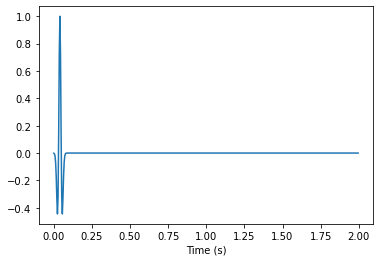

In [4]:


source_wavelet = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, ns, num_sources_per_shot))
print(source_wavelet.shape)


plt.plot(np.arange(0,nt)*dt,source_wavelet[:,0,0])
plt.xlabel('Time (s)')

### Load the velocity model 

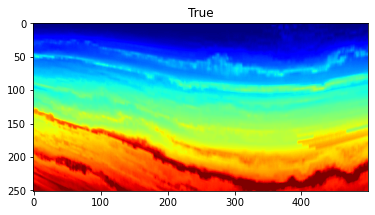

In [5]:
# Load the true model
model_true = (np.fromfile('SEAM_Vp_Elastic_N23900_chop.bin', np.float32)
              .reshape(nx, nz))
model_true = np.transpose(model_true) # I prefer having depth direction first
model_true = torch.Tensor(model_true) # Convert to a PyTorch Tensor


m_vmin, m_vmax = np.percentile(model_true.numpy(), [2,98]) 
plt.imshow(model_true, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');

## Forward modeling 

In [6]:
# Create 'true' data
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx) # create a propegator 

data_true = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [7]:
# Verify that the returned receiver amplitudes have shape
# [nt, num_shots, num_receivers_per_shot]
data_true.shape

torch.Size([500, 100, 250])

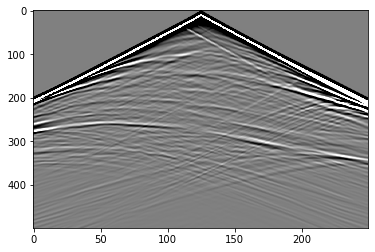

In [8]:
# Plot one shot gather
d_vmin, d_vmax = np.percentile(data_true[:,ns//2].cpu().numpy(), [2,98])

plt.imshow(data_true[:,ns//2].cpu().numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')



## Create initial model for FWI 

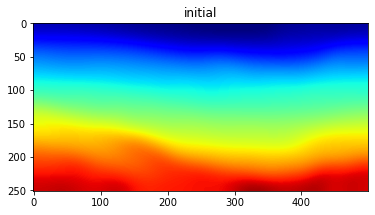

In [9]:
# Create initial guess model for inversion by smoothing the true model
model_init = scipy.ndimage.gaussian_filter(model_true.cpu().detach().numpy(),
                                           sigma=15)
model_init = torch.tensor(model_init)
# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

# plot the initial model 
plt.imshow(model_init, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('initial');

### The original notebook, notmalize the data. It might be a good idea in real data case but I am doing a different approach. Thus I commented the below lines 

In [10]:
# # To demonstrate chaining operations, during the inversion I will normalise the
# # predicted receiver amplitudes so that each trace has a maximum value of 1.
# # This will be compared (in the cost function) with the true data that has been
# # similarly scaled. I apply that scaling to the true data now.
# # This sort of scaling might be useful for real data where the absolute
# # amplitudes are often not meaningful.
# # I take the absolute value of the maximum and add a small positive value
# # (1e-10) to ensure that the denominator is never zero


# data_true_max, _ = data_true.max(dim=0, keepdim=True)
# data_true_norm = data_true / (data_true_max.abs() + 1e-10)

##  Set the optimizer and the criterion 

In [11]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params': [model], 'lr': 10}])

## Main inversion loop 

Epoch: 0 Loss:  0.02954027964733541


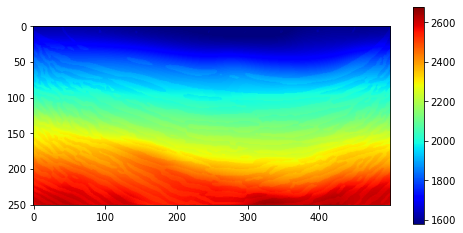

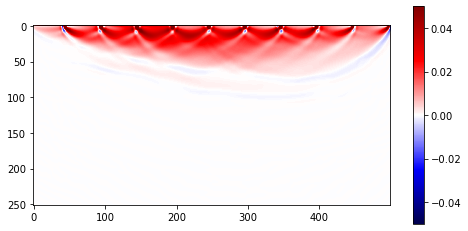

Epoch: 1 Loss:  0.01786644186358899
Epoch: 2 Loss:  0.01161676796618849
Epoch: 3 Loss:  0.00924705812940374
Epoch: 4 Loss:  0.007803419081028551
Epoch: 5 Loss:  0.005821262253448367
Epoch: 6 Loss:  0.003726133203599602
Epoch: 7 Loss:  0.0023921828251332045
Epoch: 8 Loss:  0.002130914304871112
Epoch: 9 Loss:  0.00253678418812342
Epoch: 10 Loss:  0.003035069297766313


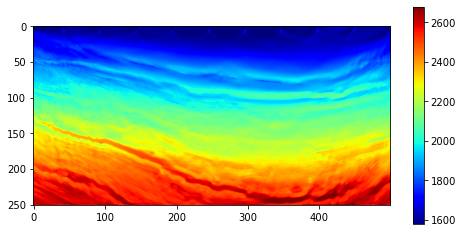

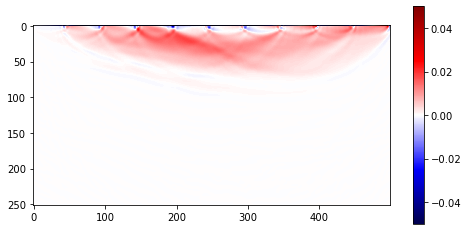

Epoch: 11 Loss:  0.00328649248695001
Epoch: 12 Loss:  0.003209870046703145
Epoch: 13 Loss:  0.0028899017779622227
Epoch: 14 Loss:  0.0024996943393489346
Epoch: 15 Loss:  0.0022027721570339054
Epoch: 16 Loss:  0.0020611854852177203
Epoch: 17 Loss:  0.002007081187912263
Epoch: 18 Loss:  0.0019170613813912496
Epoch: 19 Loss:  0.0017213069659192115
Epoch: 20 Loss:  0.0014435488556046039


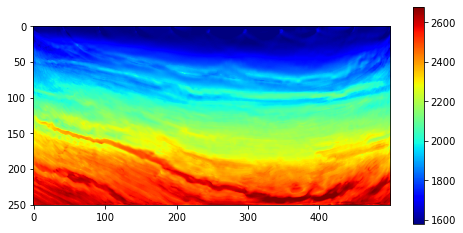

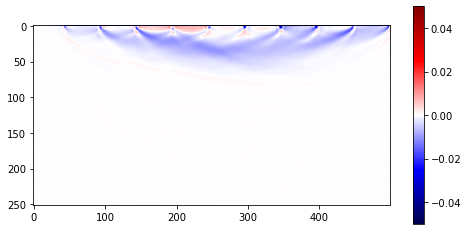

Epoch: 21 Loss:  0.00117277487879619
Epoch: 22 Loss:  0.0009956251960829832
Epoch: 23 Loss:  0.000926947126572486
Epoch: 24 Loss:  0.0009030938381329179
Epoch: 25 Loss:  0.0008418068027822301
Epoch: 26 Loss:  0.0007108464124030434
Epoch: 27 Loss:  0.0005496506819326896
Epoch: 28 Loss:  0.0004335320190875791
Epoch: 29 Loss:  0.0004054677046951838
Runtime: 124.36552381515503


In [12]:
# Iterative inversion loop
t_start = time.time()
num_shots_per_batch = int(ns / num_batches)
num_epochs = FWI_itr 
epoch_loss = []
for epoch in range(num_epochs):
  running_loss=0
  for it in range(num_batches):
    optimizer.zero_grad()
    prop = deepwave.scalar.Propagator({'vp': model}, dx)
    batch_src_wvl = source_wavelet[:,it::num_batches,].to(device)
#     batch_data_true = data_true_norm[:,it::num_batches].to(device)
    batch_data_true = data_true[:,it::num_batches].to(device)
    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    data_pred = prop(batch_src_wvl, batch_x_s, batch_x_r, dt)
#    # Normalize amplitudes by dividing by the maximum amplitude of each receiver
#     data_pred_max, _ = data_pred.max(dim=0, keepdim=True)
#     data_pred_norm = data_pred / (data_pred_max.abs() + 1e-10)
#     loss = criterion(data_pred_norm, batch_data_true)

    loss = criterion(data_pred, batch_data_true)
    running_loss += loss.item()
    loss.backward()
  epoch_loss.append(running_loss)     

  # Apply some operations to the gradient
  if epoch==0: gmax = torch.abs(model.grad).max()
  model.grad = model.grad / gmax   # normalizing by the first gradient 

  # update the model 
  optimizer.step()
  print('Epoch:', epoch, 'Loss: ', running_loss)
    
  # plotting every 10 itr   
  if epoch % 10 == 0:
    plt.figure(figsize=(8, 4))
    plt.imshow(model.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax,
               cmap='jet')
    plt.colorbar()
    
    plt.figure(figsize=(8, 4))
    plt.imshow(model.grad.cpu().detach().numpy(), 
               cmap='seismic',vmin=-0.05,vmax=0.05)
    plt.colorbar()
    plt.show()
    
t_end = time.time()
print('Runtime:', t_end - t_start)

Text(0.5, 0, 'iteration#')

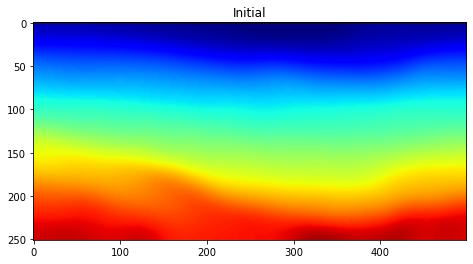

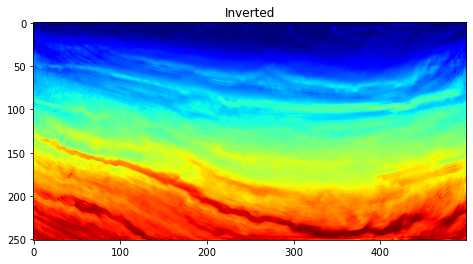

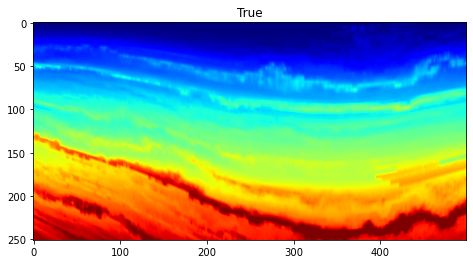

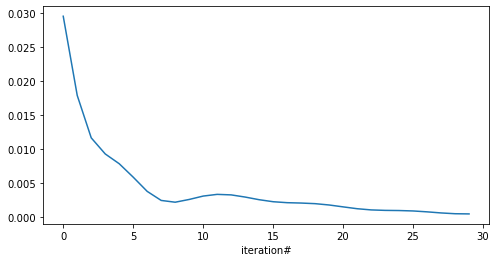

In [13]:
# Plot initial, inverted, and true models
figsize = (8, 4)
plt.figure(figsize=figsize)
plt.imshow(model_init.numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('Initial');
plt.figure(figsize=figsize)
plt.imshow(model.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('Inverted');
plt.figure(figsize=figsize)
plt.imshow(model_true.numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');


# Plot convergence 
obj = np.array(epoch_loss)
plt.figure(figsize=(8,4))
plt.plot(np.arange(num_epochs),obj)
plt.xlabel('iteration#')

## QC the inversion 

Usually, we do not know the true model. Thus, to QC the inversion we often compare the synthetic data with the observed data 

In [14]:
model = model.detach().clone().cpu()
model.requires_grad = False

# define the propegator for inverted model 
prop = deepwave.scalar.Propagator({'vp': model.to(device)}, dx) # create a propegator 
data_inv = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu() # 

# define the propegator for initial model 
prop = deepwave.scalar.Propagator({'vp': model_init.to(device)}, dx) # create a propegator 
data_init = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu() # 

Text(0.5, 1.0, 'data for initial model')

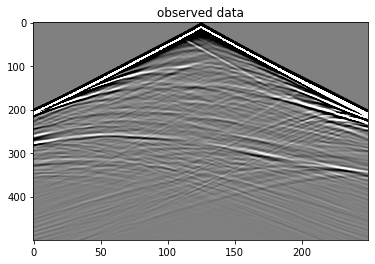

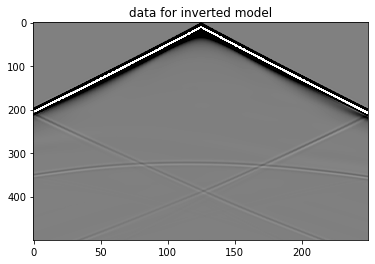

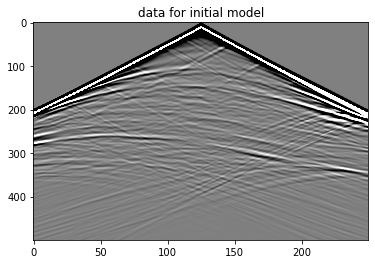

In [15]:
plt.figure()
plt.imshow(data_true[:,ns//2].numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')
plt.title('observed data')

plt.figure()
plt.imshow(data_init[:,ns//2].numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')
plt.title('data for initial model')


plt.figure()
plt.imshow(data_inv[:,ns//2].numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')
plt.title('data for inverted model')
